# Importing the libraries 

In [1]:
import tensorflow as tf 
from tensorflow.keras.layers import  Dense, Flatten, Concatenate
from tensorflow.keras.models import Model 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam , SGD
from tensorflow.keras.utils import load_img, img_to_array, img_to_array
import matplotlib.pyplot as plt 
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
import numpy as np 
from skimage.transform import resize 
import pandas as pd
import imageio

# Loading the images 

C:\Users\qnava\AppData\Local\Temp\ipykernel_16324\2942634290.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ch=imageio.imread("charmander-tight.png")
C:\Users\qnava\AppData\Local\Temp\ipykernel_16324\2942634290.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bb=imageio.imread("bulbasaur-tight.png")
C:\Users\qnava\AppData\Local\Temp\ipykernel_16324\2942634290.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or 

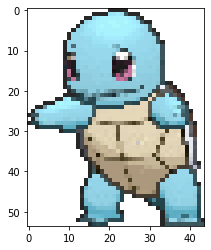

In [2]:
ch=imageio.imread("charmander-tight.png")
bb=imageio.imread("bulbasaur-tight.png")
sq=imageio.imread("squirtle-tight.png")

plt.imshow(sq)
plt.show()

In [3]:
POKE_DIM=200
ch = np.array(ch)
sq = np.array(sq)
bb = np.array(bb)
ch_H, ch_W, _ = ch.shape
sq_H, sq_W, _ = sq.shape
bb_H, bb_W, _ = bb.shape

poke_data=[
    [ch,ch_H,ch_W],
    [bb, bb_H,bb_W],
    [sq, sq_H,sq_W]
]
class_names = ["Charmander","Bulbasaure","Squirtle"]

# Building the model 

In [4]:
def custom_loss(y_true, y_pred):
    # (row, col, depth, width, class1, class2, class3, object_appeared)
    
    bce = binary_crossentropy(y_true[:,:4],y_pred[:,:4])#location 
    cce =categorical_crossentropy(y_true[:,4:7],y_pred[:,4:7])#Classification
    bce2 = binary_crossentropy(y_true[:,-1],y_pred[:,-1])#Object appeared
    
    return bce * y_true[:,-1] + cce*y_true[:,-1] + 0.5 * bce2

In [5]:
def make_model():
    vgg=tf.keras.applications.VGG16(
    input_shape=[POKE_DIM,POKE_DIM,3],
    include_top=False, 
    weights="imagenet")
    
    x=Flatten()(vgg.output)
    x1= Dense(4,activation="sigmoid")(x)
    x2= Dense(3,activation="softmax")(x)
    x3 = Dense(1,activation="sigmoid")(x)
    x=Concatenate()([x1,x2,x3])
    model =Model(vgg.input, x)
    
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.0001), metrics=["mse"])
    return model 

# Generating Data : 

## Importing background data 

In [6]:
from glob import glob 
backgrounds= []

background_files= glob("backgrounds/backgrounds/*jpg")
for file in background_files : 
    bg=np.array(load_img(file))
    backgrounds.append(bg)

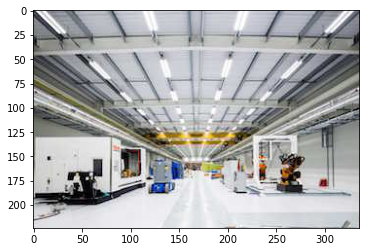

In [7]:
import random
plt.imshow(random.choice(backgrounds))
plt.show()

## Data generator 

In [8]:
def pokemon_generator_multiclass(batch_size=64): 
    while True : 
        for _ in range(50):
            X=np.zeros((batch_size,POKE_DIM,POKE_DIM ,3))
            Y=np.zeros((batch_size,8))
            
            for i in range(batch_size):
                bg= random.choice(backgrounds)
                bg_h, bg_w, _ =bg.shape
                rnd_h = np.random.randint(bg_h - POKE_DIM)
                rnd_w=np.random.randint(bg_w - POKE_DIM)
                
                X[i] = bg[rnd_h : rnd_h +POKE_DIM, rnd_w : rnd_w + POKE_DIM].copy()
                
                #25% no object, 75% for the classes :
                appear =np.random.random()
                if appear <=0.75 : 
                    #choose a Pokemon : 
                    pk_idx =np.random.randint(3)
                    pk,h,w =poke_data[pk_idx]
        
                    
                    #resize object - make it bigger or smaller 
                    scale=0.5 + np.random.random()
                    new_height = int(h*scale)
                    new_width = int(w*scale)
                    obj=resize(
                        pk,
                        (new_height, new_width),
                        preserve_range=True).astype(np.uint8)
                    
                    #flip : 
                    if np.random.random()<0.5 : 
                        obj=np.fliplr(obj)
                        
                    #choose a random file location to store the object 
                    row0 = np.random.randint(POKE_DIM -new_height)
                    col0 = np.random.randint(POKE_DIM - new_width)
                    row1 = row0 + new_height
                    col1 = col0 + new_width
                    
                    #can't just assign obj to a slice of X 
                    #since the transparent parts will be black 
                    mask = (obj[:,:,3]==0)# True where the pokemon is 0 else False 
                    bg_slice= X[i, row0: row1, col0:col1,:]
                    bg_slice= np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
                    bg_slice+= obj[:,:,:3]#"add" the pokemon to the slice 
                    X[i,row0:row1, col0:col1,:]=bg_slice
                    
                    #make targets 
                    Y[i,0] = row0/POKE_DIM
                    Y[i,1] = col0 /POKE_DIM
                    Y[i,2]= (row1 - row0)/POKE_DIM
                    Y[i,3] = (col1 - col0)/POKE_DIM
                    
                    Y[i,4+pk_idx]=1
                    #appeared ? 
                Y[i,7] =np.round(appear)
            yield X/255. , Y

## Testing the function 

In [9]:
xx=None 
yy =None

for x,y in pokemon_generator_multiclass(): 
    xx, yy = x,y
    break

[0.345 0.395 0.26  0.21  0.    0.    1.    0.   ]
Percent no obj: 0.578125
Percent charmander: 0.359375
Percent bulbasaur: 0.265625
Percent squirtle: 0.1875


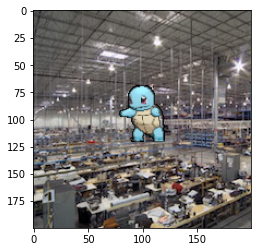

In [26]:
n=yy.shape[0]
idx=np.random.randint(n)

print(yy[idx])
print("Percent no obj:", (yy[:,7]==0).sum()/n)
print("Percent charmander:" , yy[:,4].sum()/n)
print("Percent bulbasaur:" , yy[:,5].sum()/n)
print("Percent squirtle:" , yy[:,6].sum()/n)
plt.imshow(xx[idx])
plt.show()

# Training the model 

In [28]:
model =make_model()
model.fit(pokemon_generator_multiclass(), steps_per_epoch=50, epochs=5)""

Epoch 1/5
50/50 [==============================] - 966s 19s/step - loss: 0.8238 - mse: 0.1239
Epoch 2/5
50/50 [==============================] - 901s 18s/step - loss: 0.5981 - mse: 0.0822
Epoch 3/5
50/50 [==============================] - 927s 19s/step - loss: 0.4430 - mse: 0.0599
Epoch 4/5
50/50 [==============================] - 902s 18s/step - loss: 0.4211 - mse: 0.0561
Epoch 5/5
50/50 [==============================] - 919s 18s/step - loss: 0.3946 - mse: 0.0559


# Making predictions 

In [36]:
from matplotlib.patches import Rectangle 
def pokemon_prediction_multiclass():  
    bg =random.choice(backgrounds)
    bg_h, bg_w, _ = bg.shape
    rnd_h = np.random.randint(bg_h - POKE_DIM)
    rnd_w=np.random.randint(bg_w - POKE_DIM)
    x = bg[rnd_h : rnd_h +POKE_DIM, rnd_w : rnd_w + POKE_DIM].copy()
    
    appear= np.random.random()
    if appear<=0.75 : 
        #choose a pokemon : 
        pk_idx =np.random.randint(3)
        pk,h,w =poke_data[pk_idx]
        
        #resize charmander -make it smaller or bigger : 
        scale= 0.5 + random.random()
        new_height = int(h *scale)
        new_width = int(w * scale)
        obj= resize(pk, (new_height, new_width), preserve_range=True).astype(np.uint8)

        #make flip : 
        if np.random.random()<0.5 : 
            obj=np.fliplr(obj)

        #choose a random file location to store the object 
        row0 = np.random.randint(POKE_DIM -new_height)
        col0 = np.random.randint(POKE_DIM - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width

        #can't just assign obj to a slice of X 
        #since the transparent parts will be black 

        mask = (obj[:,:,3]==0)# True where the pokemon is 0 else False 
        bg_slice= x[ row0: row1, col0:col1,:]
        bg_slice= np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
        bg_slice+= obj[:,:,:3]#"add" the pokemon to the slice 
        x[row0:row1, col0:col1,:]=bg_slice
        
        actual_class= class_names[pk_idx]
        print("true : ",row0,col0, row1, col1, actual_class)
                

    #Predict : 
    X = np.expand_dims(x,0)/255.
    p=model.predict(X)[0]

    #Plot
    fig, ax= plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    
    #Draw the box : 
    if p[-1]<=0.75 : 
        row0 = int(p[0] * POKE_DIM)
        col0 = int(p[1] *POKE_DIM)
        row1 = int(row0 + p[2] * POKE_DIM)
        col1 = int(col0 + p[3] * POKE_DIM)
        class_pred_idx= np.argmax(p[4:7])
        class_pred = class_names[class_pred_idx]
        
        print("pred : ", row0, col0, row1, col1, class_pred)
        rect=Rectangle(
            (p[1]*POKE_DIM, p[0]*POKE_DIM), #(y,x) computer format 
            p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
    else : 
        print("No object")
    plt.show()

1/1 [==============================] - 0s 81ms/step
No object


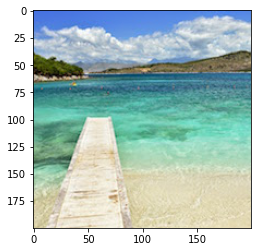

In [56]:
pokemon_prediction_multiclass()